<a href="https://colab.research.google.com/github/swarup3204/Metadata-Generation-from-Code-using-Sequence-to-Sequence-Translation-Models/blob/main/Metadata_Generation_from_Code_using_Sequence_to_Sequence_Translation_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Release and Pre Processing.


**Metadata is "data that provides information about other data", but not the content of the data, such as the text of a message or the image itself. There are many distinct types of metadata, including: Descriptive metadata – the descriptive information about a resource. It is used for discovery and identification.**

The data in the Code and Docstring (code comments or the summary string) column needs to be cleaned of alphanumeric words, punctuation's, special symbols, single characters, etc. This is required to extract relevant words for training. In the code below, we show examples of how we clean the text from the sample JavaScript dataset.

**In programming, a docstring is a string literal specified in source code that is used, like a comment, to document a specific segment of code**


In [2]:
import re  #The module re provides support for Perl-like regular expressions in Python
import pandas as pd
import numpy as np
def clean_text(column):
    for row in column:
# Split CamelCase Characters like ConcatenationOperator to Concatenation Operator
        row = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1',  str(row))).split()
        row = ' '.join(row)
# Replace tabs and newlines with a single space
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()
# Remove the special characters and numbers 
        row = re.sub(r"[<>()|&©ø\[\]\'\",.\}`$\{;@?~*!+=_\//1234567890]", " ", str(row)).lower()
# Remove Repeated words
        row = re.sub(r"\\b(\\w+)(?:\\W+\\1\\b)+", "", str(row)).lower()
# Remove punctuation at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()
# Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()
# Remove the single character (any character) between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()
        yield row
# Yield is a keyword in Python that is used to return from a function 
# without destroying the states of its local variable and when the function is called, the execution starts from the last yield statement

**re.sub(pattern, repl, string, count=0, flags=0)**

The first parameter, pattern, denotes the string/pattern that needs to be replaced.

The second parameter, repl, denotes the string/pattern with which the pattern is replaced.

The third parameter, string, denotes the string on which the re.sub() operation will be executed.

The fourth parameter, count, denotes the number of replacements that should occur.

The fifth parameter, flags, helps to shorten the code and has similar functions as that of a split operation.



**Hence using the function clean_text, we preprocess the code and docstring (summary) columns of the sample dataset**

CamelCase is the sequence of one or more than one words having the following properties: 
 

*  It is a concatenation of one or more words consisting of English letters.

*   All letters in the first word are lowercase.


*   For each of the subsequent words, the first letter is uppercase and rest of the letters are lowercase. 






In [3]:
df_code = pd.read_csv('/content/drive/MyDrive/ALGO_ZENITH_BOOTCAMP_DATASET/javascript_Sample_Dataset.csv')
#extract only the code and docstring columns
df_code_p = df_code[["code","docstring"]]
print (df_code_p["docstring"][0])
print (df_code_p.head())

Find the next separator: space, parens, comma, colon, double-quote, dollar, brackets
                                                code  \
0  function nextSeparator( str , runtime ) {\n\tv...   
1  function parseFnKeyConst( str_ , runtime ) {\n...   
2  function(name, defaults) {\n        _argValida...   
3  function(scope) {\n        if (!_argValidator....   
4  function show(url) {\n  const location = get('...   

                                           docstring  
0  Find the next separator: space, parens, comma,...  
1  An identifier that is a function, a key or a c...  
2  Configures global configuration settings, incl...  
3  Returns a configuration object that is scoped ...  
4                                               show  


In [4]:
#call clean_text function
processed_code= clean_text(df_code_p['code'])
processed_summary = clean_text(df_code_p['docstring'])
import spacy
from time import time
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
# Process the text as batches, you may should the batchsize when you use the complete dataset, empirically can be set to 5000 for > 1,00,000 records
code = [str(doc) for doc in nlp.pipe(processed_code, batch_size=50)]
#_START_ and _END_ tokens are markers to understand start and end of summaries
summary = [ str(doc) for doc in nlp.pipe(processed_summary, batch_size=50)]

**Now, as all codes and docstrings are of different lengths, you can calculate the average length of pre-processed text in both the columns and decide on the length of the codes and doscstrings**
Like first collect the length of all records in a columns (shown for the code column)

In [5]:
code_count=[]
for sent in df_code_p['code']:
    code_count.append(len(sent.split()))

Then plot a histogram to check the distribution

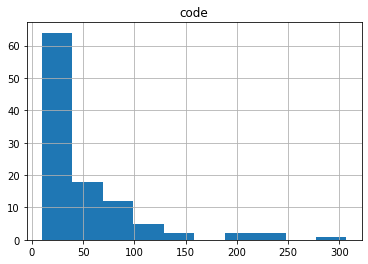

In [6]:
import matplotlib.pyplot as plt
histogram_df = pd.DataFrame()
histogram_df['code'] = code_count
histogram_df.hist(bins = 10)
plt.show()

For example based on the distribution across bins, we see that around 80\% of the codes lie within the length of 200, so we can set the maximum length as 200. Summaries are usually shorter in length.

We set

In [7]:
max_code_len = 100
max_summary_len =25
# Extract the codes and summaries within the maximum length
import numpy as np
cleaned_code = np.array(df_code_p['code'])
cleaned_summary= np.array(df_code_p['docstring'])
short_text = []
short_summary = []
for i in range(len(cleaned_code)):
  if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_code[i].split()) <= max_code_len:
    short_text.append(cleaned_code[i])
    short_summary.append(cleaned_summary[i])
    post_code = pd.DataFrame({'code': short_text,'summary': short_summary})
    post_code.head(100)
#apply start and end markers
post_code['summary'] = post_code['summary'].apply(lambda x: 'sostok ' + x \
+ ' eostok')
post_code.head()

,code,summary
0,function show(url) {\n const location = get('...,sostok show eostok
1,"function(_url,_href){\n if (!_url) ...",sostok check event need delegated eostok
2,function(_config){\n if (!_config) ...,sostok regist rewrite eostok
3,"function(_action,_name){\n var _am ...",sostok regist actions eostok
4,"function(_node,_message){\n var _mo...",sostok send message eostok


# Tokenisation - II

**We will be using the fit_on_texts tokeniser from keras**

The fit_on_texts method is a part of Keras tokenizer class which is used to update the internal vocabulary for the texts list. We need to call be before using other methods of texts_to_sequences or texts_to_matrix.

The object returned by fit_on_texts can be used to derive more information by using the following attributes (text from the keras tokeniser tutorial)-

**word_counts** : It is a dictionary of words along with the counts.

**word_docs** : Again a dictionary of words, this tells us how many documents contain this word

**word_index** : In this dictionary, we have unique integers assigned to each word.

**document_count**: This integer count will tell us the total number of documents used for fitting the tokenizer.


In [8]:
from keras.preprocessing.text import Tokenizer
t  = Tokenizer()
#This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
#or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

fit_text = 'Machine Learning'

t.fit_on_texts(fit_text)

print("Count of characters:",t.word_counts)
print("Length of text:",t.document_count)
print("Character index",t.word_index)
print("Frequency of characters:",t.word_docs)

Count of characters: OrderedDict([('m', 1), ('a', 2), ('c', 1), ('h', 1), ('i', 2), ('n', 3), ('e', 2), ('l', 1), ('r', 1), ('g', 1)])
Length of text: 16
Character index {'n': 1, 'a': 2, 'i': 3, 'e': 4, 'm': 5, 'c': 6, 'h': 7, 'l': 8, 'r': 9, 'g': 10}
Frequency of characters: defaultdict(<class 'int'>, {'m': 1, 'a': 2, 'c': 1, 'h': 1, 'i': 2, 'n': 3, 'e': 2, 'l': 1, 'r': 1, 'g': 1})


**We use the pre-processed codes and summaries that are within the maximum length and divide into train and test sets**

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_validation, y_train, y_validation = train_test_split(
np.array(post_code["code"]),
np.array(post_code["summary"]),
test_size=0.15,
random_state=0,
shuffle=True,
)

**Next we fit the tokenizer on the code sequences**

In [10]:
# we will not consider infrequent words in the vocabulary, as it may add noise
# Hence we omit words which occur only two times ( you can change the threshold to 5 in case of larger datasets)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
threshold = 2
cnt_infrequent = 0
total_cnt = 0
for key, value in x_tokenizer.word_counts.items():
    total_cnt = total_cnt + 1
    if value < threshold:
       cnt_infrequent = cnt_infrequent + 1
print("% of not frequent words in vocabulary: ", (cnt_infrequent / total_cnt) * 100)
# Remove the infrequent words
x_tokenizer = Tokenizer(num_words = total_cnt - cnt_infrequent)
x_tokenizer.fit_on_texts(list(x_train))
# Convert the code sequences to integer sequences (integer numbers ranging from 1 to the maximum vocab sizes)
x_train_seqs = x_tokenizer.texts_to_sequences(x_train)
x_validation_seqs = x_tokenizer.texts_to_sequences(x_validation)
# printing the integer sequences
print (x_train_seqs)

% of not frequent words in vocabulary:  44.2159383033419
[[3, 129, 130, 2, 20, 73, 20, 131, 132, 132, 131, 129, 38, 130, 23, 9, 9], [3, 39, 74, 24, 39, 39, 2, 21, 133, 39, 39, 39, 4, 21, 19, 21, 39, 3, 134, 4, 134, 74, 24], [3, 135, 5, 14, 28, 21, 55, 135, 3, 75, 2, 75, 4, 2, 14, 14, 75, 40, 14, 136, 14, 75, 4, 14], [3, 137, 138, 56, 1, 35, 137, 138, 1, 56, 56], [3, 46, 2, 29, 46, 47, 1, 139, 46, 2, 1, 48, 4, 76, 5, 140, 1, 1, 100, 1, 100, 141, 1, 1, 48, 1, 100, 19, 1, 140, 4, 49], [3, 15, 101, 102, 36, 5, 77, 15, 142, 143, 2, 101, 15, 102, 36, 30, 25, 144, 145, 146, 147, 41, 103, 148, 3, 78, 149, 42, 150, 151, 152, 153, 154, 155, 156, 157, 78, 158, 77, 9, 102, 159, 101, 104, 15, 15, 19, 77, 79, 104, 15, 15, 141, 77, 79, 160, 15, 23, 79, 57, 161, 14, 15, 36, 36], [3, 10, 2, 10, 4, 1, 10, 56, 80, 10, 41, 26, 21, 55, 3, 6, 2, 10, 6, 4, 1, 10, 6, 10, 6, 10, 6, 1], [3, 1, 162, 49, 1, 162, 55, 1, 58, 1, 1, 31, 103, 59, 1, 55, 1, 58, 1, 1], [3, 81, 5, 163, 81, 1, 10, 81, 1, 10, 164, 163, 3, 

In [11]:
# Pad zero upto maximum length
x_train = pad_sequences(x_train_seqs,  maxlen=max_code_len, padding='post')
x_validation = pad_sequences(x_validation_seqs, maxlen=max_code_len, padding='post')
# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1
print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 218


**Similarly we fit the tokenizer on the summary sequences**



In [12]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
threshold = 2
cnt_infrequent = 0
total_cnt = 0
for key, value in y_tokenizer.word_counts.items():
    total_cnt = total_cnt + 1
    if value < threshold:
        cnt_infrequent = cnt_infrequent + 1
y_tokenizer = Tokenizer(num_words = total_cnt - cnt_infrequent)
y_tokenizer.fit_on_texts(list(y_train))
y_train_seqs = y_tokenizer.texts_to_sequences(y_train)
y_validation_seqs = y_tokenizer.texts_to_sequences(y_validation)
y_train = pad_sequences(y_train_seqs,  maxlen=max_summary_len, padding='post')
y_validation = pad_sequences(y_validation_seqs, maxlen=max_summary_len, padding='post')
y_voc = y_tokenizer.num_words + 1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 61


In [13]:
print(len(x_train))
print(len(y_train))
print(len(x_validation))
print(len(y_validation))

37
37
7
7


In [14]:
print((x_train[0]))
print((y_train[0]))

[  3 129 130   2  20  73  20 131 132 132 131 129  38 130  23   9   9   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Encoder Decoder Architecture and Training — III

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

Set up the encoder decoder architecture

In [16]:
latent_dim = 300
embedding_dim = 200
# Encoder
encoder_inputs = Input(shape=(max_code_len, ))
# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
trainable=True)(encoder_inputs)
# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)
# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)
# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
return_sequences=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)
# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))
# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     43600       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [17]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(
[x_train, y_train[:, :-1]],
y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
epochs=50,
callbacks=[es],
batch_size=128,
validation_data=([x_validation, y_validation[:, :-1]],
y_validation.reshape(y_validation.shape[0], y_validation.shape[1], 1)[:
, 1:]),
)

Epoch 1/50
1/1 [==============================] - 18s 18s/step - loss: 4.1241 - val_loss: 3.7467
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: 3.7872 - val_loss: 1.0454
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 1.4359 - val_loss: 3.4806
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 3.4830 - val_loss: 1.3960
Epoch 4: early stopping


**In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration**

In [18]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
state_h, state_c])
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_code_len, latent_dim))
# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
initial_state=[decoder_state_input_h, decoder_state_input_c])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

**The code for generating the decoded sequence**

In [19]:
def decode_sequence(input_seq):
# Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)
# Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))
# Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
        + [e_out, e_h, e_c])
# Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word_index[sampled_token_index]
    if sampled_token != 'eostok':
        decoded_sentence += ' ' + sampled_token
# Exit condition: either hit max length or find the stop word.
    if sampled_token == 'eostok' or len(decoded_sentence.split()) \
>= max_summary_len - 1:
       stop_condition = True
# Update the target sequence (of length 1)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sampled_token_index
# Update internal states
    (e_h, e_c) = (h, c)
    return decoded_sentence

Also we define two functions to generate string sequences from integer sequences which we will use to retrieve the code and summary sequences from the tokenized integer sequences

In [20]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
        != target_word_index['eostok']:
             newString = newString + reverse_target_word_index[i] + ' '
    return newString
# To convert sequence to text
def seq2text(input_seq):
     newString = ''
     for i in input_seq:
      if i != 0:
             newString = newString + reverse_source_word_index[i] + ' '
     return newString

**Finally predict for some of the sequences**

In [ ]:
for i in range(0, 19):
    print ('Code:', seq2text(x_train[i]))
    print ('Original summary:', seq2summary(y_train[i]))
    print ('Predicted summary:', decode_sequence(x_train[i].reshape(1,max_code_len)))
    print ('\n')

Code: function which what if log console log n s s n which json what null ' ' 
Original summary: 
